In [ ]:

from keras.layers.embeddings import Embedding
from keras.layers.core import Reshape, Dense, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.layers import Input
from keras import regularizers
import numpy as np

# to load data
import re, io

embedding_dim = 128
filter_sizes = [3, 4, 5]
num_filters = 128
dropout_keep_prob = 0.5

num_epochs = 200

def clean_str(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)  # replace everything that is not a number, letter or a few chars for a white space
    string = re.sub(r"\'s", " \'s", string)     # adds a space for "'s". Example: that's -> that 's
    string = re.sub(r"\'ve", " \'ve", string)   # adds a space for "'ve". Example: you've -> you 've
    string = re.sub(r"n\'t", " n\'t", string)   # adds a space for "n't". Example: can't -> ca n't
    string = re.sub(r"\'re", " \'re", string)   # adds a space for "'re". Example: you're -> you 're
    string = re.sub(r"\'d", " \'d", string)     # adds a space for "'d". Example: you'd -> you 'd
    string = re.sub(r"\'ll", " \'ll", string)   # adds a space for "'ll". Example: you'll -> you 'll
    string = re.sub(r",", " , ", string)        # adds a space for ",". Example: you, me -> you , me
    string = re.sub(r"!", " ! ", string)        # adds a space for "!". Example: not! -> not !
    string = re.sub(r"\(", " \( ", string)      # adds a slash and space for "(". Example: and) -> and \)
    string = re.sub(r"\)", " \) ", string)      # adds a slash and space for ")". Example: (and -> \( and
    string = re.sub(r"\?", " \? ", string)      # adds a slash and space for "?". Example: and? -> and \?
    string = re.sub(r"\s{2,}", " ", string)     # Replace 2 or more whitespaces for only one
    return string.strip().lower()


def load_data_and_labels(positive_data_file, negative_data_file):
    """
    Loads MR polarity data from files, splits the data into words and generates labels.
    Returns split sentences and labels.
    """
    # Load data from files
    with io.open(positive_data_file, encoding='latin-1') as positive_file:
        positive_examples = [str(s).strip() for s in positive_file.readlines()]

    with io.open(negative_data_file, encoding='latin-1') as negative_file:
        negative_examples = [str(s).strip() for s in negative_file.readlines()]

    # Split by words
    x_text = [clean_str(sent) for sent in positive_examples + negative_examples]

    # Generate labels
    positive_labels = [[0, 1] for _ in positive_examples]
    negative_labels = [[1, 0] for _ in negative_examples]
    y = np.concatenate([positive_labels, negative_labels], 0)
    return [x_text, y]


# Load data
print("Loading data...")
x_text, y = load_data_and_labels("../datasets/rt-polarity.pos", "../datasets/rt-polarity.neg")




# Taken from http://www.wildml.com/2015/12/implementing-a-cnn-for-text-classification-in-tensorflow/
from tensorflow.contrib import learn


# Build vocabulary
max_document_length = max([len(x.split(" ")) for x in x_text])
vocab_processor = learn.preprocessing.VocabularyProcessor(max_document_length)
x = np.array(list(vocab_processor.fit_transform(x_text)))

print(x[:5])

# Randomly shuffle data
np.random.seed(10)
shuffle_indices = np.random.permutation(np.arange(len(y)))
x_shuffled = x[shuffle_indices]
y_shuffled = y[shuffle_indices]

# Split train/test set
dev_sample_index = -1 * int(len(y) * 0.1)    # Uses 10% as test (dev)
x_train, x_dev = x_shuffled[:dev_sample_index], x_shuffled[dev_sample_index:]
y_train, y_dev = y_shuffled[:dev_sample_index], y_shuffled[dev_sample_index:]

del x, y, x_shuffled, y_shuffled

print("Vocabulary Size: {:d}".format(len(vocab_processor.vocabulary_)))
print("Train/Dev split: {:d}/{:d}".format(len(y_train), len(y_dev)))
print("x_train instance 0: {}".format(x_train[0]))
print("Y Train instance 0: {}".format(y_train[0]))









# Embedding layer 
embedding = Embedding(input_dim=len(vocab_processor.vocabulary_),
                      output_dim=embedding_dim, 
                     input_length=max_document_length,
                     name="embedding")

input_sentence = Input(shape=(max_document_length,), name="input_sentence")


sentence_vector = embedding(input_sentence)   # expected shape = (batch_size, max_doc_length, embedding_dim)
sentence_vector = Reshape((1, max_document_length, embedding_dim))(sentence_vector)  # This is necessary
                        # because Conv2D expects a 4-D tensor (counting the batch_size)

# 3 Conv2D layers, with num_filters (128) of filters size = (filter_len=[3,4,5], output_dim)
# each filter produces an output of expected shape (max_doc_len - filter_len + 1)
# the input of each Conv2D layer is the same sentence_vector


pool_outputs = []

for filter_len in filter_sizes:
    conv_name = "Conv2D_{}".format(filter_len) 
    conv = Conv2D(filters=num_filters, kernel_size=(filter_len, embedding_dim), strides=(1,1), 
                  activation='relu', data_format='channels_first', padding='valid', 
                  kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l1(0.01),
                  name=conv_name)
    # expected output shape = (samples?, num_filters, new_rows=max_doc_len - filter_len + 1, new_cols=1)
    conv_output = conv(sentence_vector)
    
    max_pool_name = "MaxPool_{}".format(filter_len)
    pooling = MaxPooling2D(pool_size=(max_document_length - filter_len + 1,1), data_format='channels_first',
                          name=max_pool_name)
    # expected output (batch_size, num_filters, pooled_rows=1, pooled_cols=1)
    pool_output = pooling(conv_output)
    pool_outputs.append(pool_output)
    
# Concatenate the len(filter_sizes) outputs in only one
concatenated = Concatenate(axis=1)(pool_outputs)
# expected concatenated.shape = (batch_size, num_filters * len(filter_sizes), 1, 1)

feature_vector = Reshape((num_filters * len(filter_sizes),))(concatenated)
# expected feature_vector.shape = (batch_size, num_filters * len(filter_sizes))

feature_vector = Dropout(0.2, seed=123)(feature_vector)

final_output = Dense(2, activation='softmax', 
                     kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l1(0.01),
                    name="fully_connected")(feature_vector) # 2 because it can be positive or negative
# expected final_output.shape = (batch_size, 2)


model = Model(inputs=input_sentence, outputs=final_output)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# model.fit(x_train, y_train, batch_size=64, epochs=10, verbose=2)


ImportError: No module named 'keras'

## Inspecting the model

### History and callbacks

In [47]:
from keras.callbacks import Callback, TensorBoard, EarlyStopping

class AccuracyHistory(Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))

acc_history = AccuracyHistory()

history = model.fit(x_train, y_train, batch_size=64, epochs=50, verbose=2, validation_split=0.1,
                   callbacks=[acc_history, TensorBoard(), EarlyStopping(monitor='val_loss', patience=3, verbose=1)])



# print("AccuracyHistory:" + str(acc_history.acc))
# print()
# print("Default history:" + str(history.history))

score = model.evaluate(x_dev, y_dev, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 8636 samples, validate on 960 samples
Epoch 1/50
 - 19s - loss: 1.6188 - acc: 0.4942 - val_loss: 1.3935 - val_acc: 0.4646
Epoch 2/50
 - 18s - loss: 1.3833 - acc: 0.5019 - val_loss: 1.3769 - val_acc: 0.4646
Epoch 3/50
 - 18s - loss: 1.3715 - acc: 0.4963 - val_loss: 1.3675 - val_acc: 0.4646
Epoch 4/50
 - 18s - loss: 1.3632 - acc: 0.5019 - val_loss: 1.3600 - val_acc: 0.4646
Epoch 5/50
 - 18s - loss: 1.3564 - acc: 0.4993 - val_loss: 1.3535 - val_acc: 0.5354
Epoch 6/50
 - 18s - loss: 1.3507 - acc: 0.4963 - val_loss: 1.3486 - val_acc: 0.4646
Epoch 7/50
 - 18s - loss: 1.3463 - acc: 0.4963 - val_loss: 1.3449 - val_acc: 0.4646
Epoch 8/50
 - 18s - loss: 1.3428 - acc: 0.4956 - val_loss: 1.3420 - val_acc: 0.4646
Epoch 9/50
 - 18s - loss: 1.3400 - acc: 0.5019 - val_loss: 1.3395 - val_acc: 0.4646
Epoch 10/50
 - 18s - loss: 1.3380 - acc: 0.5019 - val_loss: 1.3375 - val_acc: 0.4646
Epoch 11/50
 - 18s - loss: 1.3364 - acc: 0.4917 - val_loss: 1.3364 - val_acc: 0.4646
Epoch 12/50
 - 18s - loss: 

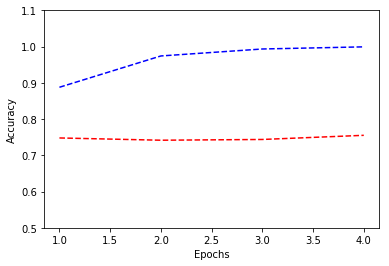

In [43]:
# To install inside the jupyter notebook
#import sys
#!{sys.executable} -m pip install matplotlib

import matplotlib.pyplot as plt

acc = history.history["acc"]
val_acc = history.history["val_acc"]
epochs_axis = range(1,len(acc) + 1)

plt.plot(epochs_axis, acc, 'b--', epochs_axis, val_acc, 'r--')
plt.ylim(0.5, 1.1)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

### Summaries

In [22]:
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_sentence (InputLayer)     (None, 56)           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 56, 128)      2401024     input_sentence[0][0]             
__________________________________________________________________________________________________
reshape_9 (Reshape)             (None, 1, 56, 128)   0           embedding[0][0]                  
__________________________________________________________________________________________________
Conv2D_3 (Conv2D)               (None, 128, 54, 1)   49280       reshape_9[0][0]                  
__________________________________________________________________________________________________
Conv2D_4 (

### Plots

In [4]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

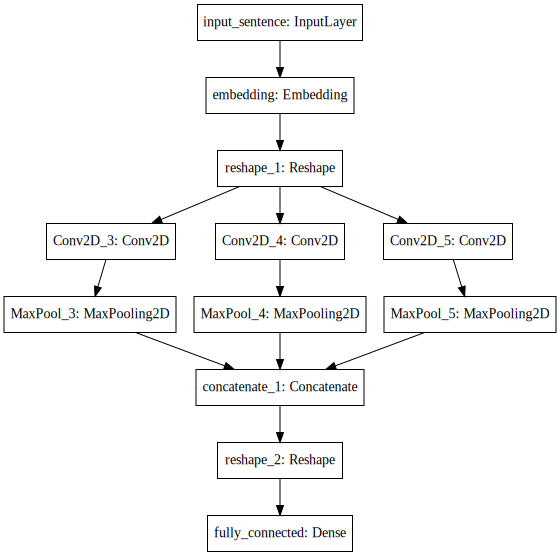

In [5]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

### Exporting

In [9]:
print(model.get_config())
print()
print(model.to_json())

{'layers': [{'class_name': 'InputLayer', 'name': 'input_sentence', 'inbound_nodes': [], 'config': {'batch_input_shape': (None, 56), 'dtype': 'float32', 'sparse': False, 'name': 'input_sentence'}}, {'class_name': 'Embedding', 'name': 'embedding', 'inbound_nodes': [[['input_sentence', 0, 0, {}]]], 'config': {'trainable': True, 'embeddings_initializer': {'class_name': 'RandomUniform', 'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}}, 'activity_regularizer': None, 'dtype': 'float32', 'input_dim': 18758, 'batch_input_shape': (None, 56), 'output_dim': 128, 'embeddings_constraint': None, 'input_length': 56, 'embeddings_regularizer': None, 'mask_zero': False, 'name': 'embedding'}}, {'class_name': 'Reshape', 'name': 'reshape_1', 'inbound_nodes': [[['embedding', 0, 0, {}]]], 'config': {'trainable': True, 'name': 'reshape_1', 'target_shape': (1, 56, 128)}}, {'class_name': 'Conv2D', 'name': 'Conv2D_3', 'inbound_nodes': [[['reshape_1', 0, 0, {}]]], 'config': {'trainable': True, 'bias_regu